In [37]:
import zipfile
import os

zip_file_path = 'RSNA/rsna-2024-lumbar-spine-degenerative-classification.zip'

extract_to = 'RSNA/data'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted {zip_file_path} to {extract_to}")

os.remove(zip_file_path)
print(f"Deleted {zip_file_path}")

FileNotFoundError: [Errno 2] No such file or directory: 'RSNA/rsna-2024-lumbar-spine-degenerative-classification.zip'

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

In [99]:
import seaborn as sns

import matplotlib.pyplot as plt
import os
import time
import numpy as np
import glob
import json
import collections
import torch
import torch.nn as nn

import matplotlib.patches as patches

from matplotlib import animation, rc
import pandas as pd

import pydicom as dicom
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # 대화형 모드

In [95]:
os.chdir('/home/jovyan/')

In [18]:
train  = pd.read_csv('RSNA/data/train.csv')
label = pd.read_csv('RSNA/data/train_label_coordinates.csv')
train_desc  = pd.read_csv('RSNA/data/train_series_descriptions.csv')
test_desc   = pd.read_csv('RSNA/data/test_series_descriptions.csv')
sub         = pd.read_csv('RSNA/data/sample_submission.csv')

In [102]:
train  = pd.read_csv('RSNA/data/train_temporal.csv')
label = pd.read_csv('RSNA/data/train_label_coordinates_temporal.csv')
train_desc  = pd.read_csv('RSNA/data/train_series_descriptions_temporal.csv')
test_desc   = pd.read_csv('RSNA/data/test_series_descriptions_temporal.csv')
sub         = pd.read_csv('RSNA/data/sample_submission.csv')

In [103]:
label.head()

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602


In [100]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [101]:
data_dir = 'RSNA/data/raw/train_images'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

FileNotFoundError: [Errno 2] No such file or directory: 'RSNA/data/raw/train_images/train'

In [104]:
def generate_image_paths(df, data_dir):
    image_paths = []
    for study_id, series_id in zip(df['study_id'], df['series_id']):
        study_dir = os.path.join(data_dir, str(study_id))
        series_dir = os.path.join(study_dir, str(series_id))
        images = os.listdir(series_dir)
        image_paths.extend([os.path.join(series_dir, img) for img in images])
    return image_paths

train_image_paths = generate_image_paths(train_desc, 'RSNA/data/raw/train_images')
test_image_paths = generate_image_paths(test_desc, 'RSNA/data/raw/test_images_temporal')

In [109]:
# Define function to reshape a single row of the DataFrame
def reshape_row(row):
    data = {'study_id': [], 'condition': [], 'level': [], 'severity': []}
    
    for column, value in row.items():
        if column not in ['study_id', 'series_id', 'instance_number', 'x', 'y', 'series_description']:
            parts = column.split('_')
            condition = ' '.join([word.capitalize() for word in parts[:-2]])
            level = parts[-2].capitalize() + '/' + parts[-1].capitalize()
            data['study_id'].append(row['study_id'])
            data['condition'].append(condition)
            data['level'].append(level)
            data['severity'].append(value)
    
    return pd.DataFrame(data)

# Reshape the DataFrame for all rows
new_train_df = pd.concat([reshape_row(row) for _, row in train.iterrows()], ignore_index=True)

# Display the first few rows of the reshaped dataframe
new_train_df.head(5)

,study_id,condition,level,severity
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild


In [110]:
# Merge the dataframes on the common columns
merged_df = pd.merge(new_train_df, label, on=['study_id', 'condition', 'level'], how='inner')
# Merge the dataframes on the common column 'series_id'
final_merged_df = pd.merge(merged_df, train_desc, on='series_id', how='inner')

In [111]:
# Merge the dataframes on the common column 'series_id'
final_merged_df = pd.merge(merged_df, train_desc, on=['series_id','study_id'], how='inner')
# Display the first few rows of the final merged dataframe
final_merged_df.head(5)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR


In [112]:
# Filter the dataframe for the given study_id and sort by instance_number
filtered_df = final_merged_df[final_merged_df['study_id'] == 1013589491].sort_values("instance_number")

# Display the resulting dataframe
filtered_df

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
11405,1013589491,Left Neural Foraminal Narrowing,L5/S1,Normal/Mild,2391548363,6,240.770301,411.216131,Sagittal T1
11420,1013589491,Right Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,231.484002,293.409742,Axial T2
11415,1013589491,Left Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,277.947591,296.033812,Axial T2
11404,1013589491,Left Neural Foraminal Narrowing,L4/L5,Normal/Mild,2391548363,7,227.194543,355.943404,Sagittal T1
11403,1013589491,Left Neural Foraminal Narrowing,L3/L4,Normal/Mild,2391548363,7,222.346058,293.844904,Sagittal T1
11401,1013589491,Left Neural Foraminal Narrowing,L1/L2,Normal/Mild,2391548363,7,247.558179,177.458555,Sagittal T1
11402,1013589491,Left Neural Foraminal Narrowing,L2/L3,Normal/Mild,2391548363,7,233.012725,234.685828,Sagittal T1
11396,1013589491,Spinal Canal Stenosis,L1/L2,Normal/Mild,482346415,10,245.476038,189.689334,Sagittal T2/STIR
11399,1013589491,Spinal Canal Stenosis,L4/L5,Moderate,482346415,10,238.435979,366.511699,Sagittal T2/STIR
11398,1013589491,Spinal Canal Stenosis,L3/L4,Moderate,482346415,10,232.381129,310.201597,Sagittal T2/STIR


In [113]:
# Sort final_merged_df by study_id, series_id, and series_description
sorted_final_merged_df = final_merged_df[final_merged_df['study_id'] == 1013589491].sort_values(by=['series_id', 'series_description', 'instance_number'])
sorted_final_merged_df

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
11396,1013589491,Spinal Canal Stenosis,L1/L2,Normal/Mild,482346415,10,245.476038,189.689334,Sagittal T2/STIR
11397,1013589491,Spinal Canal Stenosis,L2/L3,Normal/Mild,482346415,10,235.251580,250.434645,Sagittal T2/STIR
11398,1013589491,Spinal Canal Stenosis,L3/L4,Moderate,482346415,10,232.381129,310.201597,Sagittal T2/STIR
11399,1013589491,Spinal Canal Stenosis,L4/L5,Moderate,482346415,10,238.435979,366.511699,Sagittal T2/STIR
11400,1013589491,Spinal Canal Stenosis,L5/S1,Normal/Mild,482346415,10,257.921341,421.652869,Sagittal T2/STIR
11415,1013589491,Left Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,277.947591,296.033812,Axial T2
11420,1013589491,Right Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,231.484002,293.409742,Axial T2
11414,1013589491,Left Subarticular Stenosis,L4/L5,Moderate,598943280,13,266.694844,257.081995,Axial T2
11419,1013589491,Right Subarticular Stenosis,L4/L5,Normal/Mild,598943280,13,228.060888,255.755492,Axial T2
11413,1013589491,Left Subarticular Stenosis,L3/L4,Moderate,598943280,19,262.366864,246.262046,Axial T2


In [114]:
import pandas as pd
train_path = 'RSNA/data/raw'
# Create the row_id column
final_merged_df['row_id'] = (
    final_merged_df['study_id'].astype(str) + '_' +
    final_merged_df['condition'].str.lower().str.replace(' ', '_') + '_' +
    final_merged_df['level'].str.lower().str.replace('/', '_')
)

# Create the image_path column
final_merged_df['image_path'] = (
    f'{train_path}/train_images/' + 
    final_merged_df['study_id'].astype(str) + '/' +
    final_merged_df['series_id'].astype(str) + '/' +
    final_merged_df['instance_number'].astype(str) + '.dcm'
)

# Note: Check image path, since there's 1 instance id, for 1 image, but there's many more images other than the ones labelled in the instance ID. 

# Display the updated dataframe
final_merged_df.head(5)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,RSNA/data/raw/train_images/4003253/702807833/8...
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3,RSNA/data/raw/train_images/4003253/702807833/8...
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4,RSNA/data/raw/train_images/4003253/702807833/8...
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l4_l5,RSNA/data/raw/train_images/4003253/702807833/8...
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l5_s1,RSNA/data/raw/train_images/4003253/702807833/8...


In [115]:
final_merged_df[final_merged_df["severity"] == "Normal/Mild"].value_counts().sum()
final_merged_df[final_merged_df["severity"] == "Moderate"].value_counts().sum()

7942

In [117]:
final_merged_df[final_merged_df["severity"] == "Moderate"].value_counts().sum()

7942

In [118]:
# Define the base path for test images
base_path = 'RSNA/data/raw/test_images_temporal'

# Function to get image paths for a series
def get_image_paths(row):
    series_path = os.path.join(base_path, str(row['study_id']), str(row['series_id']))
    if os.path.exists(series_path):
        return [os.path.join(series_path, f) for f in os.listdir(series_path) if os.path.isfile(os.path.join(series_path, f))]
    return []

# Mapping of series_description to conditions
condition_mapping = {
    'Sagittal T1': {'left': 'left_neural_foraminal_narrowing', 'right': 'right_neural_foraminal_narrowing'},
    'Axial T2': {'left': 'left_subarticular_stenosis', 'right': 'right_subarticular_stenosis'},
    'Sagittal T2/STIR': 'spinal_canal_stenosis'
}

# Create a list to store the expanded rows
expanded_rows = []

# Expand the dataframe by adding new rows for each file path
for index, row in test_desc.iterrows():
    image_paths = get_image_paths(row)
    conditions = condition_mapping.get(row['series_description'], {})
    if isinstance(conditions, str):  # Single condition
        conditions = {'left': conditions, 'right': conditions}
    for side, condition in conditions.items():
        for image_path in image_paths:
            expanded_rows.append({
                'study_id': row['study_id'],
                'series_id': row['series_id'],
                'series_description': row['series_description'],
                'image_path': image_path,
                'condition': condition,
                'row_id': f"{row['study_id']}_{condition}"
            })

# Create a new dataframe from the expanded rows
expanded_test_desc = pd.DataFrame(expanded_rows)

# Display the resulting dataframe
expanded_test_desc.head(5)

,study_id,series_id,series_description,image_path,condition,row_id
0,41477684,2595734107,Sagittal T2/STIR,RSNA/data/raw/test_images_temporal/41477684/25...,spinal_canal_stenosis,41477684_spinal_canal_stenosis
1,41477684,2595734107,Sagittal T2/STIR,RSNA/data/raw/test_images_temporal/41477684/25...,spinal_canal_stenosis,41477684_spinal_canal_stenosis
2,41477684,2595734107,Sagittal T2/STIR,RSNA/data/raw/test_images_temporal/41477684/25...,spinal_canal_stenosis,41477684_spinal_canal_stenosis
3,41477684,2595734107,Sagittal T2/STIR,RSNA/data/raw/test_images_temporal/41477684/25...,spinal_canal_stenosis,41477684_spinal_canal_stenosis
4,41477684,2595734107,Sagittal T2/STIR,RSNA/data/raw/test_images_temporal/41477684/25...,spinal_canal_stenosis,41477684_spinal_canal_stenosis


In [119]:
# change severity column labels
#Normal/Mild': 'normal_mild', 'Moderate': 'moderate', 'Severe': 'severe'}
final_merged_df['severity'] = final_merged_df['severity'].map({'Normal/Mild': 'normal_mild', 'Moderate': 'moderate', 'Severe': 'severe'})

In [120]:
test_data = expanded_test_desc
train_data = final_merged_df

In [121]:
import os

train_path = 'RSNA/data/raw'
# Define a function to check if a path exists
def check_exists(path):
    return os.path.exists(path)

# Define a function to check if a study ID directory exists
def check_study_id(row):
    study_id = row['study_id']
    path = f'{train_path}/train_images/{study_id}'
    return check_exists(path)

# Define a function to check if a series ID directory exists
def check_series_id(row):
    study_id = row['study_id']
    series_id = row['series_id']
    path = f'{train_path}/train_images/{study_id}/{series_id}'
    return check_exists(path)

# Define a function to check if an image file exists
def check_image_exists(row):
    image_path = row['image_path']
    return check_exists(image_path)

# Apply the functions to the train_data dataframe
train_data['study_id_exists'] = train_data.apply(check_study_id, axis=1)
train_data['series_id_exists'] = train_data.apply(check_series_id, axis=1)
train_data['image_exists'] = train_data.apply(check_image_exists, axis=1)

# Filter train_data
train_data = train_data[(train_data['study_id_exists']) & (train_data['series_id_exists']) & (train_data['image_exists'])]

In [126]:
train_data.head(5)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path,study_id_exists,series_id_exists,image_exists
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,RSNA/data/raw/train_images/4003253/702807833/8...,True,True,True
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3,RSNA/data/raw/train_images/4003253/702807833/8...,True,True,True
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4,RSNA/data/raw/train_images/4003253/702807833/8...,True,True,True
3,4003253,Spinal Canal Stenosis,L4/L5,normal_mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l4_l5,RSNA/data/raw/train_images/4003253/702807833/8...,True,True,True
4,4003253,Spinal Canal Stenosis,L5/S1,normal_mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l5_s1,RSNA/data/raw/train_images/4003253/702807833/8...,True,True,True


In [123]:
def load_dicom(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

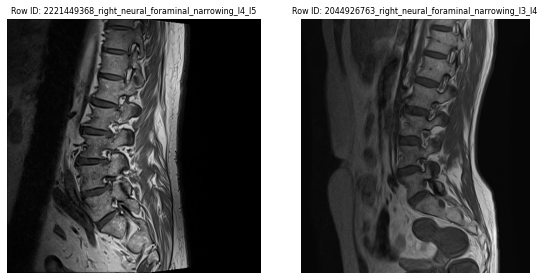

In [124]:
# Load images randomly
import random
images = []
row_ids = []
selected_indices = random.sample(range(len(train_data)), 2)
for i in selected_indices:
    image = load_dicom(train_data['image_path'][i])
    images.append(image)
    row_ids.append(train_data['row_id'][i])

# Plot images
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].set_title(f'Row ID: {row_ids[i]}', fontsize=8)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [127]:
len(train_data)

48632

In [139]:
import re

# natural_keys 함수 정의
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text)]

# RSNA24TrainDataset 클래스 정의 (이전 코드 유지)
class RSNA24TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def get_img_paths(self, row, series_desc):
        # Extract series ID and study ID
        study_id = row['study_id']
        series_id = row['series_id']
        # Construct image paths based on the series and study ID
        img_paths = glob.glob(f'{row["image_path"]}/*.dcm')
        img_paths = sorted(img_paths, key=natural_keys)  # 자연스러운 순서로 정렬
        return img_paths

    def read_dcm_ret_arr(self, src_path):
        dicom_data = pydicom.dcmread(src_path)
        image = dicom_data.pixel_array
        image = (image - image.min()) / (image.max() - image.min() + 1e-6) * 255
        img = cv2.resize(image, (224, 224), interpolation=cv2.INTER_CUBIC)  # Resize to the desired shape
        return img

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = np.zeros((224, 224, 30), dtype=np.uint8)  # Adjust this to the correct number of slices/channels
        severity_label = row['severity']  # Severity label
        study_id = row['study_id']

        # Initialize image arrays
        all_imgs = []

        # Process Sagittal T1 series
        allimgs_st1 = self.get_img_paths(row, 'Sagittal T1')
        if len(allimgs_st1) == 0:
            print(study_id, ': Sagittal T1, has no images')
        else:
            all_imgs.extend(allimgs_st1)

        # Process Sagittal T2/STIR series
        allimgs_st2 = self.get_img_paths(row, 'Sagittal T2/STIR')
        if len(allimgs_st2) == 0:
            print(study_id, ': Sagittal T2/STIR, has no images')
        else:
            all_imgs.extend(allimgs_st2)

        # Process Axial T2 series
        allimgs_at2 = self.get_img_paths(row, 'Axial T2')
        if len(allimgs_at2) == 0:
            print(study_id, ': Axial T2, has no images')
        else:
            all_imgs.extend(allimgs_at2)

        # Fill the image array
        if len(all_imgs) > 0:
            step = len(all_imgs) / 30.0  # Adjust to the number of slices/channels
            for j, i in enumerate(np.arange(0, len(all_imgs), step)):
                try:
                    ind2 = max(0, int(i))
                    img = self.read_dcm_ret_arr(all_imgs[ind2])
                    x[..., j] = img.astype(np.uint8)
                except Exception as e:
                    print(f'Failed to load image {ind2} from study {study_id}: {e}')
                    pass

        # Apply transforms
        if self.transform is not None:
            x = self.transform(image=x)['image']

        x = x.transpose(2, 0, 1)  # Convert to the correct channel format (C, H, W)

        # Return the processed image and the label
        label_map = {'normal_mild': 0, 'moderate': 1, 'severe': 2}
        label = label_map[severity_label]

        return x, label

In [144]:
class RSNA24TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def get_img_paths(self, row, series_desc):
        # Extract series ID and study ID
        study_id = row['study_id']
        series_id = row['series_id']
        # Construct image paths based on the series and study ID
        img_paths = glob.glob(f'{row["image_path"]}/*.dcm')
        img_paths = sorted(img_paths, key=natural_keys)
        return img_paths

    def read_dcm_ret_arr(self, src_path):
        dicom_data = pydicom.dcmread(src_path)
        image = dicom_data.pixel_array
        image = (image - image.min()) / (image.max() - image.min() + 1e-6) * 255
        img = cv2.resize(image, (224, 224), interpolation=cv2.INTER_CUBIC)  # Resize to the desired shape
        return img

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = np.zeros((224, 224, 30), dtype=np.uint8)  # Adjust this to the correct number of slices/channels
        severity_label = row['severity']  # Severity label
        study_id = row['study_id']

        # Initialize image arrays
        all_imgs = []

        # Process Sagittal T1 series
        allimgs_st1 = self.get_img_paths(row, 'Sagittal T1')
        if len(allimgs_st1) == 0:
            print(study_id, ': Sagittal T1, has no images')
        else:
            all_imgs.extend(allimgs_st1)

        # Process Sagittal T2/STIR series
        allimgs_st2 = self.get_img_paths(row, 'Sagittal T2/STIR')
        if len(allimgs_st2) == 0:
            print(study_id, ': Sagittal T2/STIR, has no images')
        else:
            all_imgs.extend(allimgs_st2)

        # Process Axial T2 series
        allimgs_at2 = self.get_img_paths(row, 'Axial T2')
        if len(allimgs_at2) == 0:
            print(study_id, ': Axial T2, has no images')
        else:
            all_imgs.extend(allimgs_at2)

        # Fill the image array
        if len(all_imgs) > 0:
            step = len(all_imgs) / 30.0  # Adjust to the number of slices/channels
            for j, i in enumerate(np.arange(0, len(all_imgs), step)):
                try:
                    ind2 = max(0, int(i))
                    img = self.read_dcm_ret_arr(all_imgs[ind2])
                    x[..., j] = img.astype(np.uint8)
                except Exception as e:
                    print(f'Failed to load image {ind2} from study {study_id}: {e}')
                    pass
                
        # Apply transforms
        if self.transform is not None:
            x = self.transform(x)

        x = x.transpose(2, 0, 1)  # Convert to the correct channel format (C, H, W)

        # Return the processed image and the label
        label_map = {'normal_mild': 0, 'moderate': 1, 'severe': 2}
        label = label_map[severity_label]

        return x, label

In [182]:
import torch
import torchio as tio
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import cv2
import glob
import pydicom

class RSNA24TrainDataset(Dataset):
    def __init__(self, df, transform=None, tio_transform=None):
        self.df = df
        self.transform = transform  # torchvision transforms for 2D images
        self.tio_transform = tio_transform  # torchio transforms for 3D images

    def __len__(self):
        return len(self.df)

    def get_img_paths(self, row, series_desc):
        study_id = row['study_id']
        series_id = row['series_id']
        img_paths = glob.glob(f'{row["image_path"]}/*.dcm')
        img_paths = sorted(img_paths, key=lambda text: int(text.split('/')[-1].split('.')[0]))  # Natural sorting
        return img_paths

    def read_dcm_ret_arr(self, src_path):
        dicom_data = pydicom.dcmread(src_path)
        image = dicom_data.pixel_array
        image = (image - image.min()) / (image.max() - image.min() + 1e-6) * 255
        img = cv2.resize(image, (224, 224), interpolation=cv2.INTER_CUBIC)
        return img

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        severity_label = row['severity']
        study_id = row['study_id']
        
        all_imgs = []

        # Process Sagittal T1, T2/STIR, Axial T2 series
        allimgs_st1 = self.get_img_paths(row, 'Sagittal T1')
        allimgs_st2 = self.get_img_paths(row, 'Sagittal T2/STIR')
        allimgs_at2 = self.get_img_paths(row, 'Axial T2')

        all_imgs.extend(allimgs_st1)
        all_imgs.extend(allimgs_st2)
        all_imgs.extend(allimgs_at2)

        if len(all_imgs) > 0:
            step = len(all_imgs) / 30.0
            x = np.zeros((224, 224, 30), dtype=np.uint8)  # 3D volume

            for j, i in enumerate(np.arange(0, len(all_imgs), step)):
                try:
                    ind2 = max(0, int(i))
                    img = self.read_dcm_ret_arr(all_imgs[ind2])
                    x[..., j] = img.astype(np.uint8)
                except Exception as e:
                    print(f'Failed to load image {ind2} from study {study_id}: {e}')
                    pass

            # 3D torchio transform 적용
            if self.tio_transform is not None:
                x_torchio = torch.tensor(x).float().unsqueeze(0)  # Add channel dimension for 3D transform
                subject = tio.Subject(image=tio.ScalarImage(tensor=x_torchio))
                transformed = self.tio_transform(subject)
                x_torchio = transformed['image'].data.squeeze(0)
                return x_torchio, self.get_label(severity_label)

            # 2D torchvision.transforms 적용
            if self.transform is not None:
                # 중간 슬라이스를 PIL 이미지로 변환
                mid_slice = x[..., x.shape[2] // 2]
                x_pil = Image.fromarray(mid_slice.astype('uint8'), 'L')
                x_pil = self.transform(x_pil)
                return x_pil, self.get_label(severity_label)

        return torch.tensor([]), self.get_label(severity_label)

    def get_label(self, severity_label):
        label_map = {'normal_mild': 0, 'moderate': 1, 'severe': 2}
        return label_map[severity_label]


ModuleNotFoundError: No module named 'cv2'

In [184]:
from PIL import Image
import torch
import torchvision.transforms as transforms

class RSNA24TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def get_img_paths(self, row, series_desc):
        study_id = row['study_id']
        series_id = row['series_id']
        img_paths = glob.glob(f'{row["image_path"]}/*.dcm')
        img_paths = sorted(img_paths, key=natural_keys)
        return img_paths

    def read_dcm_ret_arr(self, src_path):
        dicom_data = pydicom.dcmread(src_path)
        image = dicom_data.pixel_array
        image = (image - image.min()) / (image.max() - image.min() + 1e-6) * 255
        img = cv2.resize(image, (224, 224), interpolation=cv2.INTER_CUBIC)
        return img

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = np.zeros((224, 224, 30), dtype=np.uint8)
        severity_label = row['severity']
        study_id = row['study_id']
        
        all_imgs = []

        # Process Sagittal T1, T2/STIR, Axial T2 series
        allimgs_st1 = self.get_img_paths(row, 'Sagittal T1')
        allimgs_st2 = self.get_img_paths(row, 'Sagittal T2/STIR')
        allimgs_at2 = self.get_img_paths(row, 'Axial T2')

        all_imgs.extend(allimgs_st1)
        all_imgs.extend(allimgs_st2)
        all_imgs.extend(allimgs_at2)

        if len(all_imgs) > 0:
            step = len(all_imgs) / 30.0
            for j, i in enumerate(np.arange(0, len(all_imgs), step)):
                try:
                    ind2 = max(0, int(i))
                    img = self.read_dcm_ret_arr(all_imgs[ind2])
                    x[..., j] = img.astype(np.uint8)
                except Exception as e:
                    print(f'Failed to load image {ind2} from study {study_id}: {e}')
                    pass

        # 변환: numpy 배열을 PIL 이미지로 변환
        x_pil = Image.fromarray(x.astype('uint8'), 'RGB')

        # Apply transforms
        if self.transform is not None:
            x_pil = self.transform(x_pil)

        # Return the processed image and the label
        label_map = {'normal_mild': 0, 'moderate': 1, 'severe': 2}
        label = label_map[severity_label]

        return x_pil, label

In [151]:
from sklearn.model_selection import train_test_split

# 시리즈 설명을 기준으로 stratify를 적용
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['series_description'])

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}")

Train size: 38905, Validation size: 9727


In [143]:
print(train_df)

         study_id                         condition  level     severity  \
8687    786544183             Spinal Canal Stenosis  L4/L5  normal_mild   
25102  2265301200        Left Subarticular Stenosis  L2/L3  normal_mild   
32140  2838898600  Right Neural Foraminal Narrowing  L4/L5  normal_mild   
33613  2975955864  Right Neural Foraminal Narrowing  L1/L2  normal_mild   
27577  2480600394             Spinal Canal Stenosis  L4/L5       severe   
...           ...                               ...    ...          ...   
46339  4094479531       Right Subarticular Stenosis  L3/L4  normal_mild   
15570  1400326269   Left Neural Foraminal Narrowing  L2/L3  normal_mild   
9315    832603302  Right Neural Foraminal Narrowing  L1/L2  normal_mild   
42182  3721755136   Left Neural Foraminal Narrowing  L2/L3  normal_mild   
41788  3688443239   Left Neural Foraminal Narrowing  L2/L3  normal_mild   

        series_id  instance_number           x           y series_description  \
8687    410008846 

In [180]:
from torch.utils.data import DataLoader
import torchio as tio

# torchio를 활용한 데이터 증강 기법 설정
train_transform = tio.Compose([
    tio.RandomFlip(axes=(0, 1)),             # 확률적으로 X 또는 Y 축에 대해 뒤집기
    tio.RandomAffine(scales=(0.9, 1.1), degrees=10),  # 스케일과 회전을 랜덤하게 적용
    tio.RandomElasticDeformation(),          # 탄성 변형
    tio.ZNormalization(),                    # Z-Score 정규화
    tio.RandomGamma(log_gamma=(-0.3, 0.3)),  # 감마 왜곡
    tio.RandomMotion(),                      # 모션 아티팩트 추가
    tio.RandomNoise(mean=0, std=0.1),        # 랜덤 노이즈 추가
    tio.RandomBiasField(coefficients=0.5),   # 바이어스 필드 왜곡
    tio.RandomBlur(std=(0.25, 1.5))          # 블러 효과 적용
])

# 검증용 데이터에서는 데이터 증강을 적용하지 않고 정규화만 수행
val_transform = tio.Compose([
    tio.ZNormalization()  # 정규화만 적용
])

# CustomDataset을 이용한 DataLoader 생성
def create_dataloader(df, batch_size=32, transform=None, shuffle=True):
    dataset = RSNA24TrainDataset(df, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Train/Validation DataLoader 생성
train_loader = create_dataloader(train_df, batch_size=32, transform=train_transform)
val_loader = create_dataloader(val_df, batch_size=32, transform=val_transform, shuffle=False)

In [185]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Train과 Validation에 대해 다른 Transform 설정
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # ±10도 회전
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# CustomDataset을 이용한 DataLoader 생성
def create_dataloader(df, batch_size=32, transform=None, shuffle=True):
    dataset = RSNA24TrainDataset(df, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Train/Validation DataLoader 생성
train_loader = create_dataloader(train_df, batch_size=32, transform=train_transform)
val_loader = create_dataloader(val_df, batch_size=32, transform=val_transform, shuffle=False)


In [152]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Transform 설정
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# CustomDataset을 이용한 DataLoader 생성
def create_dataloader(df, batch_size=32, transform=None, shuffle=True):
    dataset = RSNA24TrainDataset(df, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Train/Validation DataLoader 생성
train_loader = create_dataloader(train_df, batch_size=32, transform=transform)
val_loader = create_dataloader(val_df, batch_size=32, transform=transform, shuffle=False)

In [186]:
import os

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 손실 및 정확도를 저장할 리스트
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

# 모델 학습 및 검증 루프
def train_model(model, criterion, optimizer, num_epochs=15, save_path="efficientv2_model.pth"):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 epoch마다 학습 및 검증 단계 설정
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 학습 모드
                dataloader = train_loader
            else:
                model.eval()   # 평가 모드
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # 데이터셋을 반복
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 옵티마이저 경사 초기화
                optimizer.zero_grad()

                # 학습 단계에서만 역전파 + 최적화
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계에서만 역전파 및 옵티마이저 스텝
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계 계산
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # 성능 저장
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            # 최고 성능 모델 저장
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                # 최적 모델 가중치 저장
                torch.save(best_model_wts, save_path)
                print(f'Best model weights saved at epoch {epoch}')

    print(f'Best val Acc: {best_acc:.4f}')

    # 최적의 모델 가중치로 모델 로드
    model.load_state_dict(best_model_wts)
    return model

# 모델 학습
model = train_model(model, criterion, optimizer, num_epochs=15, save_path="efficientv2_model.pth")

Epoch 0/14
----------


100%|██████████| 1216/1216 [12:08<00:00,  1.67it/s]


train Loss: 0.6698 Acc: 0.7732


100%|██████████| 304/304 [02:59<00:00,  1.69it/s]


val Loss: 0.6972 Acc: 0.7744
Best model weights saved at epoch 0
Epoch 1/14
----------


100%|██████████| 1216/1216 [12:00<00:00,  1.69it/s]


train Loss: 0.6701 Acc: 0.7732


100%|██████████| 304/304 [02:58<00:00,  1.70it/s]


val Loss: 0.6890 Acc: 0.7744
Epoch 2/14
----------


 39%|███▉      | 478/1216 [04:44<07:19,  1.68it/s]


KeyboardInterrupt: 

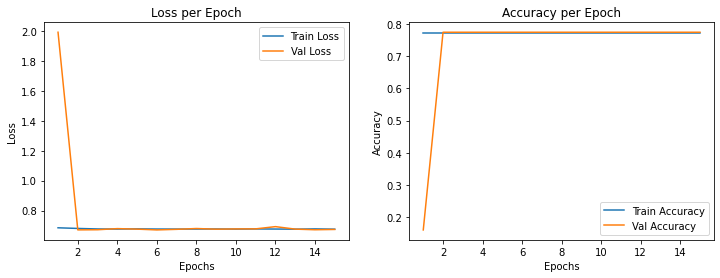

In [155]:
# 학습 및 검증 손실, 정확도 시각화
def plot_history():
    epochs = range(1, len(train_loss_history) + 1)

    # 손실 그래프
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_history, label='Train Loss')
    plt.plot(epochs, val_loss_history, label='Val Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc_history, label='Train Accuracy')
    plt.plot(epochs, val_acc_history, label='Val Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# 학습 및 검증 기록 시각화
plot_history()

In [44]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [46]:
import os
print(os.environ.get('CUDA_VISIBLE_DEVICES'))


MIG-6a2dce29-efc6-57de-a98b-1f88d1114329


In [47]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 첫 번째 GPU 사용

In [50]:
import torch
import torch.nn as nn
import torchvision.models as models

class CustomEfficientNetV2(nn.Module):
    def __init__(self, num_classes=3, pretrained_weights=None):
        super(CustomEfficientNetV2, self).__init__()
        self.model = models.efficientnet_v2_s(weights=None)
        if pretrained_weights:
            # 가중치를 CPU로 로드하고 strict=False 설정
            state_dict = torch.load(pretrained_weights, map_location='cpu')
            self.model.load_state_dict(state_dict, strict=False)
        num_ftrs = self.model.classifier[-1].in_features
        self.model.classifier[-1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

    def unfreeze_model(self):
        # Unfreeze the last 20 layers, keeping BatchNorm layers frozen
        for layer in list(self.model.features.children())[-20:]:
            if not isinstance(layer, nn.BatchNorm2d):
                for param in layer.parameters():
                    param.requires_grad = True
        
        # Unfreeze the classifier
        for param in self.model.classifier.parameters():
            param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path to the locally uploaded weights file
weights_path = 'RSNA/outputs/models/best_model_1.pth'

# Initialize models and move to the appropriate device
sagittal_t1_model = CustomEfficientNetV2(num_classes=3, pretrained_weights=weights_path).to(device)
axial_t2_model = CustomEfficientNetV2(num_classes=3, pretrained_weights=weights_path).to(device)
sagittal_t2stir_model = CustomEfficientNetV2(num_classes=3, pretrained_weights=weights_path).to(device)

# Optionally freeze initial layers
for param in sagittal_t1_model.model.features.parameters():
    param.requires_grad = False
for param in axial_t2_model.model.features.parameters():
    param.requires_grad = False
for param in sagittal_t2stir_model.model.features.parameters():
    param.requires_grad = False

# Unfreeze the final fully connected layer
for param in sagittal_t1_model.model.classifier.parameters():
    param.requires_grad = True
for param in axial_t2_model.model.classifier.parameters():
    param.requires_grad = True
for param in sagittal_t2stir_model.model.classifier.parameters():
    param.requires_grad = True

# Training parameters
criterion = nn.CrossEntropyLoss()

# Initialize separate optimizers for each model
optimizer_sagittal_t1 = torch.optim.Adam(sagittal_t1_model.model.classifier.parameters(), lr=0.001)
optimizer_axial_t2 = torch.optim.Adam(axial_t2_model.model.classifier.parameters(), lr=0.001)
optimizer_sagittal_t2stir = torch.optim.Adam(sagittal_t2stir_model.model.classifier.parameters(), lr=0.001)

# Store the models and optimizers in dictionaries for easy access
models = {
    'Sagittal T1': sagittal_t1_model,
    'Axial T2': axial_t2_model,
    'Sagittal T2/STIR': sagittal_t2stir_model,
}
optimizers = {
    'Sagittal T1': optimizer_sagittal_t1,
    'Axial T2': optimizer_axial_t2,
    'Sagittal T2/STIR': optimizer_sagittal_t2stir,
}

In [51]:
# Count trainable parameters
trainable_params = sum(p.numel() for p in sagittal_t1_model.parameters() if p.requires_grad)
print(f"Number of parameters: {trainable_params}")

Number of parameters: 3843


In [53]:
label_map = {'normal_mild': 0, 'moderate': 1, 'severe': 2}

for images, labels in trainloader_t2:
    labels = torch.tensor([label_map[label] for label in labels])
    labels = labels.to(device)
    print(labels)
    break

tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')


In [54]:
import torch.optim.lr_scheduler as lr_scheduler
from copy import deepcopy

def train_model(model, trainloader, valloader, len_train, len_val, optimizer, num_epochs=10, patience=3):
    # Learning rate scheduler
    scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    
    best_val_acc = 0.0
    best_model_wts = deepcopy(model.state_dict())
    counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        
        with tqdm(trainloader, unit="batch") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device), torch.tensor([label_map[label] for label in labels]).to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                
                probabilities = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(probabilities, 1)
                correct_train += (predicted == labels).sum().item()
                
                tepoch.set_postfix(epoch=epoch+1)
        
        scheduler.step()
        
        train_loss /= len(trainloader)
        train_acc = 100 * correct_train / len_train
        
        model.eval()
        val_loss, correct_val = 0, 0
        with torch.no_grad():
            with tqdm(valloader, unit="batch") as vepoch:
                for images, labels in vepoch:
                    images, labels = images.to(device), torch.tensor([label_map[label] for label in labels]).to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    
                    probabilities = torch.softmax(outputs, dim=1).squeeze(0)
                    _, predicted = torch.max(probabilities, 1)
                    correct_val += (predicted == labels).sum().item()
                    
                    vepoch.set_postfix(epoch=epoch+1)
        
        val_loss /= len(valloader)
        val_acc = 100 * correct_val / len_val
        
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Save the best model and check for early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = deepcopy(model.state_dict())
            counter = 0
            torch.save(best_model_wts, f'best_model_{epoch+1}.pth')
        else:
            counter += 1
        
        # Early stopping
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_val_acc

In [56]:
# Training all models
for desc, model in models.items():
    if desc == 'Sagittal T1':
        trainloader, valloader, len_train, len_val = trainloader_t1, valloader_t1, len_train_t1, len_val_t1
    elif desc == 'Axial T2':
        trainloader, valloader, len_train, len_val = trainloader_t2, valloader_t2, len_train_t2, len_val_t2
    elif desc == 'Sagittal T2/STIR':
        trainloader, valloader, len_train, len_val = trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir
    
    print(f"Training model for {desc}")
    train_model(model, trainloader, valloader, len_train, len_val, optimizers[desc])

Training model for Sagittal T1


100%|██████████| 493/493 [03:11<00:00,  2.58batch/s, epoch=1]


Epoch 1, Train Loss: 0.6443, Train Acc: 77.84%, Val Loss: 0.7984, Val Acc: 77.76%


100%|██████████| 493/493 [03:13<00:00,  2.55batch/s, epoch=2]


Epoch 2, Train Loss: 0.6393, Train Acc: 77.80%, Val Loss: 0.6900, Val Acc: 78.12%


100%|██████████| 493/493 [03:08<00:00,  2.61batch/s, epoch=3]


Epoch 3, Train Loss: 0.6412, Train Acc: 77.83%, Val Loss: 0.6875, Val Acc: 78.17%


100%|██████████| 493/493 [03:09<00:00,  2.60batch/s, epoch=4]


Epoch 4, Train Loss: 0.6387, Train Acc: 77.84%, Val Loss: 0.6950, Val Acc: 78.22%


100%|██████████| 493/493 [03:13<00:00,  2.55batch/s, epoch=5]


Epoch 5, Train Loss: 0.6414, Train Acc: 77.86%, Val Loss: 0.7767, Val Acc: 78.14%


100%|██████████| 493/493 [03:08<00:00,  2.62batch/s, epoch=6]


Epoch 6, Train Loss: 0.6413, Train Acc: 77.83%, Val Loss: 0.6624, Val Acc: 78.19%


100%|██████████| 493/493 [03:13<00:00,  2.55batch/s, epoch=7]


Epoch 7, Train Loss: 0.6422, Train Acc: 77.88%, Val Loss: 0.7987, Val Acc: 78.12%
Early stopping triggered after 7 epochs
Training model for Axial T2


100%|██████████| 481/481 [03:00<00:00,  2.67batch/s, epoch=1]


Epoch 1, Train Loss: 0.8194, Train Acc: 70.34%, Val Loss: 1.1238, Val Acc: 69.87%


100%|██████████| 481/481 [03:01<00:00,  2.65batch/s, epoch=2]


Epoch 2, Train Loss: 0.8183, Train Acc: 70.19%, Val Loss: 1.0000, Val Acc: 71.48%


100%|██████████| 481/481 [03:04<00:00,  2.61batch/s, epoch=3]


Epoch 3, Train Loss: 0.7942, Train Acc: 71.04%, Val Loss: 0.8837, Val Acc: 71.43%


100%|██████████| 481/481 [03:05<00:00,  2.59batch/s, epoch=4]


Epoch 4, Train Loss: 0.7932, Train Acc: 71.09%, Val Loss: 0.8138, Val Acc: 71.40%


100%|██████████| 481/481 [03:22<00:00,  2.37batch/s, epoch=5]


Epoch 5, Train Loss: 0.7883, Train Acc: 71.16%, Val Loss: 0.9846, Val Acc: 71.35%
Early stopping triggered after 5 epochs
Training model for Sagittal T2/STIR


100%|██████████| 244/244 [01:49<00:00,  2.22batch/s, epoch=1]


Epoch 1, Train Loss: 0.4873, Train Acc: 87.60%, Val Loss: 0.6084, Val Acc: 87.13%


100%|██████████| 244/244 [01:36<00:00,  2.53batch/s, epoch=2]


Epoch 2, Train Loss: 0.4798, Train Acc: 87.61%, Val Loss: 0.5417, Val Acc: 87.08%


100%|██████████| 244/244 [01:32<00:00,  2.65batch/s, epoch=3]


Epoch 3, Train Loss: 0.4595, Train Acc: 87.83%, Val Loss: 0.6232, Val Acc: 87.13%


100%|██████████| 244/244 [01:36<00:00,  2.52batch/s, epoch=4]

Epoch 4, Train Loss: 0.4581, Train Acc: 87.84%, Val Loss: 0.5664, Val Acc: 87.13%
Early stopping triggered after 4 epochs


In [66]:
levels = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']

# Function to update row_id with levels
def update_row_id(row, levels):
    level = levels[row.name % len(levels)]
    return f"{row['study_id']}_{row['condition']}_{level}"

# Update row_id in expanded_test_desc to include levels
expanded_test_desc['row_id'] = expanded_test_desc.apply(lambda row: update_row_id(row, levels), axis=1)

In [156]:
expanded_test_desc = pd.read_csv('RSNA/expanded_test_desc.csv')

In [157]:
# Define a custom test dataset class
class TestDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_path = self.dataframe['image_path'][index]
        image = load_dicom(image_path)  # Define this function to load your DICOM images
        if self.transform:
            image = self.transform(image)
        return image

# Define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# Create a test dataset and dataloader
test_dataset = TestDataset(expanded_test_desc, transform)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [158]:
for image in testloader:
    print(image.shape)
    break

torch.Size([1, 3, 224, 224])


In [159]:
# Function to get the model based on series_description
def get_model(series_description):
    return models.get(series_description, None)

# Function to make predictions on the test data
def predict_test_data(testloader, expanded_test_desc):
    predictions = []
    normal_mild_probs = []
    moderate_probs = []
    severe_probs = []
    
    for model in models.values():
        model.eval()
        
    with torch.no_grad():
        for idx, images in enumerate(tqdm(testloader)):
            images = images.to(device)
            series_description = expanded_test_desc.iloc[idx]['series_description']
            model = get_model(series_description)
            if model:
                model.eval()  # Set the model to eval mode
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1).squeeze(0)
                normal_mild_probs.append(probs[0].item())
                moderate_probs.append(probs[1].item())
                severe_probs.append(probs[2].item())
                predictions.append(probs)
            else:
                normal_mild_probs.append(None)
                moderate_probs.append(None)
                severe_probs.append(None)
                predictions.append(None)
    return normal_mild_probs, moderate_probs, severe_probs, predictions

In [160]:
# Make predictions on the test data
normal_mild_probs, moderate_probs, severe_probs, test_predictions = predict_test_data(testloader, expanded_test_desc)

AttributeError: module 'torchvision.models' has no attribute 'values'

In [71]:
test_predictions[0]

tensor([0.7792, 0.1940, 0.0268], device='cuda:0')

In [72]:
# Add predictions and probabilities to the test DataFrame
expanded_test_desc['normal_mild'] = normal_mild_probs
expanded_test_desc['moderate'] = moderate_probs
expanded_test_desc['severe'] = severe_probs

In [73]:
submission = expanded_test_desc[["row_id","normal_mild","moderate","severe"]]

In [76]:
submission.head(10)

,row_id,normal_mild,moderate,severe
0,44036939_left_neural_foraminal_narrowing_l1_l2,0.779232,0.193996,0.026772
1,44036939_left_neural_foraminal_narrowing_l2_l3,0.779190,0.194134,0.026676
2,44036939_left_neural_foraminal_narrowing_l3_l4,0.786030,0.187856,0.026114
3,44036939_left_neural_foraminal_narrowing_l4_l5,0.785015,0.188514,0.026470
4,44036939_left_neural_foraminal_narrowing_l5_s1,0.780008,0.193175,0.026816
5,44036939_left_neural_foraminal_narrowing_l1_l2,0.780555,0.192782,0.026662
6,44036939_left_neural_foraminal_narrowing_l2_l3,0.779559,0.193802,0.026640
7,44036939_left_neural_foraminal_narrowing_l3_l4,0.777846,0.195204,0.026950
8,44036939_left_neural_foraminal_narrowing_l4_l5,0.782359,0.191220,0.026421
9,44036939_left_neural_foraminal_narrowing_l5_s1,0.780154,0.193305,0.026541


In [81]:
len(submission)

194

In [83]:
submission.to_csv("RSNA/outputs/results/submission.csv", index=False)

In [77]:
import numpy as np
import pandas as pd
import pandas.api.types
import sklearn.metrics


class ParticipantVisibleError(Exception):
    pass


def get_condition(full_location: str) -> str:
    # Given an input like spinal_canal_stenosis_l1_l2 extracts 'spinal'
    for injury_condition in ['spinal', 'foraminal', 'subarticular']:
        if injury_condition in full_location:
            return injury_condition
    raise ValueError(f'condition not found in {full_location}')


def score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        row_id_column_name: str,
        any_severe_scalar: float
    ) -> float:
    '''
    Pseudocode:
    1. Calculate the sample weighted log loss for each medical condition:
    2. Derive a new any_severe label.
    3. Calculate the sample weighted log loss for the new any_severe label.
    4. Return the average of all of the label group log losses as the final score, normalized for the number of columns in each group.
       This mitigates the impact of spinal stenosis having only half as many columns as the other two conditions.
    '''

    target_levels = ['normal_mild', 'moderate', 'severe']

    # Run basic QC checks on the inputs
    if not pandas.api.types.is_numeric_dtype(submission[target_levels].values):
        raise ParticipantVisibleError('All submission values must be numeric')

    if not np.isfinite(submission[target_levels].values).all():
        raise ParticipantVisibleError('All submission values must be finite')

    if solution[target_levels].min().min() < 0:
        raise ParticipantVisibleError('All labels must be at least zero')
    if submission[target_levels].min().min() < 0:
        raise ParticipantVisibleError('All predictions must be at least zero')

    solution['study_id'] = solution['row_id'].apply(lambda x: x.split('_')[0])
    solution['location'] = solution['row_id'].apply(lambda x: '_'.join(x.split('_')[1:]))
    solution['condition'] = solution['row_id'].apply(get_condition)

    del solution[row_id_column_name]
    del submission[row_id_column_name]
    assert sorted(submission.columns) == sorted(target_levels)

    submission['study_id'] = solution['study_id']
    submission['location'] = solution['location']
    submission['condition'] = solution['condition']

    condition_losses = []
    condition_weights = []
    for condition in ['spinal', 'foraminal', 'subarticular']:
        condition_indices = solution.loc[solution['condition'] == condition].index.values
        condition_loss = sklearn.metrics.log_loss(
            y_true=solution.loc[condition_indices, target_levels].values,
            y_pred=submission.loc[condition_indices, target_levels].values,
            sample_weight=solution.loc[condition_indices, 'sample_weight'].values
        )
        condition_losses.append(condition_loss)
        condition_weights.append(1)

    any_severe_spinal_labels = pd.Series(solution.loc[solution['condition'] == 'spinal'].groupby('study_id')['severe'].max())
    any_severe_spinal_weights = pd.Series(solution.loc[solution['condition'] == 'spinal'].groupby('study_id')['sample_weight'].max())
    any_severe_spinal_predictions = pd.Series(submission.loc[submission['condition'] == 'spinal'].groupby('study_id')['severe'].max())
    any_severe_spinal_loss = sklearn.metrics.log_loss(
        y_true=any_severe_spinal_labels,
        y_pred=any_severe_spinal_predictions,
        sample_weight=any_severe_spinal_weights
    )
    condition_losses.append(any_severe_spinal_loss)
    condition_weights.append(any_severe_scalar)
    return np.average(condition_losses, weights=condition_weights)

In [79]:
solution = train.melt(id_vars=["study_id"], var_name="full_label", value_name="severity")
solution["row_id"] = solution.apply(lambda row: str(row.study_id) + "_" + row.full_label, axis=1)
solution.severity = solution.severity.fillna("Normal/Mild")
solution.loc[solution.severity == "Normal/Mild", "normal_mild"] = 1
solution.loc[solution.severity == "Moderate", "moderate"] = 1
solution.loc[solution.severity == "Severe", "severe"] = 1

solution.loc[solution.severity == "Normal/Mild", "sample_weight"] = 1
solution.loc[solution.severity == "Moderate", "sample_weight"] = 2
solution.loc[solution.severity == "Severe", "sample_weight"] = 3

solution = solution[["study_id", "row_id", "normal_mild", "moderate", "severe", "sample_weight"]]
solution = solution.fillna(0)
solution = solution.sort_values(by=["row_id"])
solution.to_csv("temp_train_solution.csv", index=False)

In [87]:
expanded_test_desc

,study_id,series_id,series_description,image_path,condition,row_id,normal_mild,moderate,severe
0,44036939,2828203845,Sagittal T1,RSNA/data/raw/test_images/44036939/2828203845/...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing_l1_l2,0.779232,0.193996,0.026772
1,44036939,2828203845,Sagittal T1,RSNA/data/raw/test_images/44036939/2828203845/...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing_l2_l3,0.779190,0.194134,0.026676
2,44036939,2828203845,Sagittal T1,RSNA/data/raw/test_images/44036939/2828203845/...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing_l3_l4,0.786030,0.187856,0.026114
3,44036939,2828203845,Sagittal T1,RSNA/data/raw/test_images/44036939/2828203845/...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing_l4_l5,0.785015,0.188514,0.026470
4,44036939,2828203845,Sagittal T1,RSNA/data/raw/test_images/44036939/2828203845/...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing_l5_s1,0.780008,0.193175,0.026816
...,...,...,...,...,...,...,...,...,...
189,44036939,3844393089,Sagittal T2/STIR,RSNA/data/raw/test_images/44036939/3844393089/...,spinal_canal_stenosis,44036939_spinal_canal_stenosis_l5_s1,0.865534,0.068287,0.066179
190,44036939,3844393089,Sagittal T2/STIR,RSNA/data/raw/test_images/44036939/3844393089/...,spinal_canal_stenosis,44036939_spinal_canal_stenosis_l1_l2,0.875441,0.062188,0.062371
191,44036939,3844393089,Sagittal T2/STIR,RSNA/data/raw/test_images/44036939/3844393089/...,spinal_canal_stenosis,44036939_spinal_canal_stenosis_l2_l3,0.884336,0.055944,0.059720
192,44036939,3844393089,Sagittal T2/STIR,RSNA/data/raw/test_images/44036939/3844393089/...,spinal_canal_stenosis,44036939_spinal_canal_stenosis_l3_l4,0.878781,0.058846,0.062372


In [88]:
!pip install timm

In [92]:
import torch
import timm
from PIL import Image
from torchvision import transforms

# 사전 학습된 EfficientNetV2 모델 로드
model = timm.create_model('efficientnetv2_s', pretrained=False, num_classes=3)  # 예시: num_classes=3

# 모델을 평가 모드로 전환
model.eval()

# GPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 여기서부터는 모델로 예측을 수행할 수 있습니다.

In [212]:
import torch
import torch.nn as nn
import timm

# 사전 학습된 EfficientNetV2 모델 로드
model = timm.create_model('efficientnet_b4', pretrained=True, num_classes=3)  # num_classes=3으로 설정하여 새로운 데이터셋에 맞춤

# 모델을 평가 모드로 전환
model.eval()

# GPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Fine-tuning을 위해 마지막 레이어 교체
num_ftrs = model.classifier.in_features  # 이전 fully connected layer의 입력 피처 수
model.classifier = nn.Linear(num_ftrs, 3)  # 새로운 fully connected layer 생성 (3개의 클래스 분류)

for param in model.parameters():
    param.requires_grad = False  # 모든 레이어 동결

# 마지막 두 개의 블록을 학습 가능하게 설정 (또는 적절히 조정)
for param in model.blocks[-2:].parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True  # 마지막 레이어 학습 가능하게 설정

model = model.to(device)

In [213]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()

# L2 정규화를 위한 Weight Decay 추가
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# 학습률 스케줄러 (StepLR 예시)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# 조기 종료를 위한 설정
early_stopping_patience = 5
best_val_loss = float('inf')
early_stopping_counter = 0

# 손실 및 정확도를 저장할 리스트
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

# 모델 학습 및 검증 루프
def train_model(model, criterion, optimizer, num_epochs=15, save_path="efficientv2_model.pth"):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 epoch마다 학습 및 검증 단계 설정
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 학습 모드
                dataloader = train_loader
            else:
                model.eval()   # 평가 모드
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # 데이터셋을 반복
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 옵티마이저 경사 초기화
                optimizer.zero_grad()

                # 학습 단계에서만 역전파 + 최적화
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계에서만 역전파 및 옵티마이저 스텝
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계 계산
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # 성능 저장
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

                # 최고 성능 모델 저장 및 Early Stopping 적용
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    early_stopping_counter = 0
                    best_model_wts = model.state_dict()
                    # 최적 모델 가중치 저장
                    torch.save(best_model_wts, save_path)
                    print(f'Best model weights saved at epoch {epoch}')
                else:
                    early_stopping_counter += 1
                    if early_stopping_counter >= early_stopping_patience:
                        print("Early stopping!")
                        model.load_state_dict(best_model_wts)
                        return model

        # 학습률 스케줄러 업데이트
        scheduler.step()

    print(f'Best val Acc: {best_acc:.4f}')

    # 최적의 모델 가중치로 모델 로드
    model.load_state_dict(best_model_wts)
    return model

# 모델 학습
model = train_model(model, criterion, optimizer, num_epochs=15, save_path="efficientv2_model.pth")


Epoch 0/14
----------


100%|██████████| 1216/1216 [12:47<00:00,  1.58it/s]


train Loss: 0.6736 Acc: 0.7722


100%|██████████| 304/304 [03:02<00:00,  1.67it/s]

val Loss: 0.6743 Acc: 0.7744


UnboundLocalError: local variable 'best_val_loss' referenced before assignment

In [210]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()

# L2 정규화를 위한 Weight Decay 추가
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

# 학습률 스케줄러 (StepLR 예시)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# 조기 종료를 위한 설정
early_stopping_patience = 5
best_val_loss = float('inf')  # 초기 값을 매우 큰 값으로 설정
early_stopping_counter = 0

# 손실 및 정확도를 저장할 리스트
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

# 모델 학습 및 검증 루프
def train_model(model, criterion, optimizer, num_epochs=15, save_path="efficientv2_model.pth"):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    global best_val_loss  # 외부 변수를 참조하도록 설정

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 epoch마다 학습 및 검증 단계 설정
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 학습 모드
                dataloader = train_loader
            else:
                model.eval()   # 평가 모드
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # 데이터셋을 반복
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 옵티마이저 경사 초기화
                optimizer.zero_grad()

                # 학습 단계에서만 역전파 + 최적화
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계에서만 역전파 및 옵티마이저 스텝
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계 계산
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # 성능 저장
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

                # 최고 성능 모델 저장 및 Early Stopping 적용은 validation 단계에서만 수행
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    early_stopping_counter = 0
                    best_model_wts = model.state_dict()
                    # 최적 모델 가중치 저장
                    torch.save(best_model_wts, save_path)
                    print(f'Best model weights saved at epoch {epoch}')
                else:
                    early_stopping_counter += 1
                    if early_stopping_counter >= early_stopping_patience:
                        print("Early stopping!")
                        model.load_state_dict(best_model_wts)
                        return model

        # 학습률 스케줄러 업데이트
        scheduler.step()

    print(f'Best val Acc: {best_acc:.4f}')

    # 최적의 모델 가중치로 모델 로드
    model.load_state_dict(best_model_wts)
    return model

# 모델 학습
model = train_model(model, criterion, optimizer, num_epochs=15, save_path="efficientv2_model.pth")


Epoch 0/14
----------


  0%|          | 6/1216 [00:04<13:55,  1.45it/s]


KeyboardInterrupt: 

In [211]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# L2 정규화를 위한 Weight Decay 추가한 AdamW 옵티마이저 정의
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-4)

# 학습률 스케줄러 정의 (ReduceLROnPlateau 사용)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# 학습 및 검증 기록을 위한 리스트 초기화
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

# 모델 학습 함수 정의
def train_model(model, criterion, optimizer, scheduler, num_epochs=15, save_path="best_model.pth"):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    global best_val_loss  # 외부 변수를 참조하도록 설정

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 학습 모드
                dataloader = train_loader
            else:
                model.eval()   # 평가 모드
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        
                        # 그라디언트 모니터링
                        for name, param in model.named_parameters():
                            if param.requires_grad and param.grad is not None:
                                print(f"{name} - Grad: {param.grad.abs().mean().item():.6f}")
                        
                        optimizer.step()

                # 통계 계산
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

                # 검증 성능이 향상되었을 때 최적 모델 저장
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                    torch.save(best_model_wts, save_path)
                    print(f'Best model weights saved at epoch {epoch}')

        # 학습률 스케줄러 업데이트
        scheduler.step(epoch_loss)

    # 최적의 모델 가중치로 모델 로드
    model.load_state_dict(best_model_wts)
    print(f'Best val Acc: {best_acc:.4f}')
    return model

# 모델 학습
model = train_model(model, criterion, optimizer, scheduler, num_epochs=15, save_path="best_model.pth")


Epoch 0/14
----------


  0%|          | 1/1216 [00:00<11:20,  1.78it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  0%|          | 2/1216 [00:01<11:52,  1.70it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  0%|          | 3/1216 [00:01<12:52,  1.57it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  0%|          | 4/1216 [00:02<14:42,  1.37it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  0%|          | 5/1216 [00:03<14:00,  1.44it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  0%|          | 6/1216 [00:03<13:33,  1.49it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  1%|          | 7/1216 [00:04<12:49,  1.57it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  1%|          | 8/1216 [00:05<13:52,  1.45it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  1%|          | 9/1216 [00:06<14:33,  1.38it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  1%|          | 10/1216 [00:06<14:27,  1.39it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  1%|          | 11/1216 [00:07<13:40,  1.47it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  1%|          | 12/1216 [00:08<13:10,  1.52it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  1%|          | 13/1216 [00:08<13:39,  1.47it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  1%|          | 14/1216 [00:09<13:32,  1.48it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  1%|          | 15/1216 [00:10<13:02,  1.53it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  1%|▏         | 16/1216 [00:10<13:21,  1.50it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  1%|▏         | 17/1216 [00:11<13:31,  1.48it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  1%|▏         | 18/1216 [00:12<13:37,  1.47it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  2%|▏         | 19/1216 [00:12<13:08,  1.52it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  2%|▏         | 20/1216 [00:13<12:46,  1.56it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  2%|▏         | 21/1216 [00:14<13:10,  1.51it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  2%|▏         | 22/1216 [00:14<13:24,  1.48it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  2%|▏         | 23/1216 [00:15<13:30,  1.47it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  2%|▏         | 24/1216 [00:16<12:58,  1.53it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  2%|▏         | 25/1216 [00:16<12:39,  1.57it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  2%|▏         | 26/1216 [00:17<13:05,  1.52it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  2%|▏         | 27/1216 [00:18<13:04,  1.51it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  2%|▏         | 28/1216 [00:18<13:28,  1.47it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  2%|▏         | 29/1216 [00:19<14:10,  1.40it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  2%|▏         | 30/1216 [00:20<14:18,  1.38it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  3%|▎         | 31/1216 [00:20<13:20,  1.48it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  3%|▎         | 32/1216 [00:21<12:57,  1.52it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  3%|▎         | 33/1216 [00:22<13:08,  1.50it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  3%|▎         | 34/1216 [00:22<13:42,  1.44it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  3%|▎         | 35/1216 [00:23<13:19,  1.48it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  3%|▎         | 36/1216 [00:24<12:15,  1.60it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  3%|▎         | 37/1216 [00:24<12:10,  1.61it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  3%|▎         | 38/1216 [00:25<12:22,  1.59it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  3%|▎         | 39/1216 [00:26<12:58,  1.51it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  3%|▎         | 40/1216 [00:26<13:30,  1.45it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  3%|▎         | 41/1216 [00:27<13:15,  1.48it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  3%|▎         | 42/1216 [00:28<12:44,  1.53it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  4%|▎         | 43/1216 [00:28<13:28,  1.45it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  4%|▎         | 44/1216 [00:29<14:24,  1.36it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  4%|▎         | 45/1216 [00:30<14:18,  1.36it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  4%|▍         | 46/1216 [00:30<13:13,  1.47it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  4%|▍         | 47/1216 [00:31<13:10,  1.48it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  4%|▍         | 48/1216 [00:32<13:13,  1.47it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  4%|▍         | 49/1216 [00:33<13:35,  1.43it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  4%|▍         | 50/1216 [00:33<13:36,  1.43it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  4%|▍         | 51/1216 [00:34<12:30,  1.55it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  4%|▍         | 52/1216 [00:34<12:09,  1.59it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  4%|▍         | 53/1216 [00:35<12:33,  1.54it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  4%|▍         | 54/1216 [00:36<12:16,  1.58it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  5%|▍         | 55/1216 [00:36<12:05,  1.60it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  5%|▍         | 56/1216 [00:37<12:23,  1.56it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  5%|▍         | 57/1216 [00:38<12:35,  1.53it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  5%|▍         | 58/1216 [00:38<13:06,  1.47it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  5%|▍         | 59/1216 [00:39<12:22,  1.56it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  5%|▍         | 60/1216 [00:40<12:32,  1.54it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  5%|▌         | 61/1216 [00:40<12:14,  1.57it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  5%|▌         | 62/1216 [00:41<11:49,  1.63it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  5%|▌         | 63/1216 [00:41<12:11,  1.58it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  5%|▌         | 64/1216 [00:42<12:44,  1.51it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  5%|▌         | 65/1216 [00:43<12:46,  1.50it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  5%|▌         | 66/1216 [00:44<13:41,  1.40it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  6%|▌         | 67/1216 [00:44<12:37,  1.52it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  6%|▌         | 68/1216 [00:45<11:30,  1.66it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  6%|▌         | 69/1216 [00:45<11:04,  1.72it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  6%|▌         | 70/1216 [00:46<11:04,  1.72it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  6%|▌         | 71/1216 [00:46<11:39,  1.64it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  6%|▌         | 72/1216 [00:47<11:56,  1.60it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  6%|▌         | 73/1216 [00:48<11:26,  1.66it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  6%|▌         | 74/1216 [00:48<12:00,  1.58it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  6%|▌         | 75/1216 [00:49<11:49,  1.61it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  6%|▋         | 76/1216 [00:50<11:41,  1.62it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  6%|▋         | 77/1216 [00:50<12:09,  1.56it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  6%|▋         | 78/1216 [00:51<12:16,  1.54it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  6%|▋         | 79/1216 [00:52<12:13,  1.55it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  7%|▋         | 80/1216 [00:52<12:30,  1.51it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  7%|▋         | 81/1216 [00:53<12:45,  1.48it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  7%|▋         | 82/1216 [00:54<12:21,  1.53it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  7%|▋         | 83/1216 [00:54<12:02,  1.57it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  7%|▋         | 84/1216 [00:55<11:58,  1.58it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  7%|▋         | 85/1216 [00:55<11:31,  1.64it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  7%|▋         | 86/1216 [00:56<11:27,  1.64it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  7%|▋         | 87/1216 [00:57<12:03,  1.56it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  7%|▋         | 88/1216 [00:57<12:18,  1.53it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  7%|▋         | 89/1216 [00:58<12:10,  1.54it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  7%|▋         | 90/1216 [00:59<12:53,  1.46it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  7%|▋         | 91/1216 [00:59<12:53,  1.46it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  8%|▊         | 92/1216 [01:00<13:10,  1.42it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  8%|▊         | 93/1216 [01:01<12:59,  1.44it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  8%|▊         | 94/1216 [01:02<13:00,  1.44it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  8%|▊         | 95/1216 [01:02<12:12,  1.53it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  8%|▊         | 96/1216 [01:03<11:56,  1.56it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  8%|▊         | 97/1216 [01:03<11:50,  1.58it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  8%|▊         | 98/1216 [01:04<11:50,  1.57it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  8%|▊         | 99/1216 [01:05<11:35,  1.61it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  8%|▊         | 100/1216 [01:05<11:02,  1.68it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  8%|▊         | 101/1216 [01:06<11:28,  1.62it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  8%|▊         | 102/1216 [01:06<11:45,  1.58it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  8%|▊         | 103/1216 [01:07<11:47,  1.57it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  9%|▊         | 104/1216 [01:08<11:56,  1.55it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  9%|▊         | 105/1216 [01:08<12:12,  1.52it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

  9%|▊         | 106/1216 [01:09<12:09,  1.52it/s]

blocks.5.0.conv_pw.weight - Grad: 0.000000
blocks.5.0.bn1.weight - Grad: 0.000000
blocks.5.0.bn1.bias - Grad: 0.000000
blocks.5.0.conv_dw.weight - Grad: 0.000000
blocks.5.0.bn2.weight - Grad: 0.000000
blocks.5.0.bn2.bias - Grad: 0.000000
blocks.5.0.se.conv_reduce.weight - Grad: 0.000000
blocks.5.0.se.conv_reduce.bias - Grad: 0.000000
blocks.5.0.se.conv_expand.weight - Grad: 0.000000
blocks.5.0.se.conv_expand.bias - Grad: 0.000000
blocks.5.0.conv_pwl.weight - Grad: 0.000000
blocks.5.0.bn3.weight - Grad: 0.000000
blocks.5.0.bn3.bias - Grad: 0.000000
blocks.5.1.conv_pw.weight - Grad: 0.000000
blocks.5.1.bn1.weight - Grad: 0.000000
blocks.5.1.bn1.bias - Grad: 0.000000
blocks.5.1.conv_dw.weight - Grad: 0.000000
blocks.5.1.bn2.weight - Grad: 0.000000
blocks.5.1.bn2.bias - Grad: 0.000000
blocks.5.1.se.conv_reduce.weight - Grad: 0.000000
blocks.5.1.se.conv_reduce.bias - Grad: 0.000000
blocks.5.1.se.conv_expand.weight - Grad: 0.000000
blocks.5.1.se.conv_expand.bias - Grad: 0.000000
blocks.5.1.c

KeyboardInterrupt: 

In [201]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)


conv_stem.weight False
bn1.weight False
bn1.bias False
blocks.0.0.conv_dw.weight False
blocks.0.0.bn1.weight False
blocks.0.0.bn1.bias False
blocks.0.0.se.conv_reduce.weight False
blocks.0.0.se.conv_reduce.bias False
blocks.0.0.se.conv_expand.weight False
blocks.0.0.se.conv_expand.bias False
blocks.0.0.conv_pw.weight False
blocks.0.0.bn2.weight False
blocks.0.0.bn2.bias False
blocks.0.1.conv_dw.weight False
blocks.0.1.bn1.weight False
blocks.0.1.bn1.bias False
blocks.0.1.se.conv_reduce.weight False
blocks.0.1.se.conv_reduce.bias False
blocks.0.1.se.conv_expand.weight False
blocks.0.1.se.conv_expand.bias False
blocks.0.1.conv_pw.weight False
blocks.0.1.bn2.weight False
blocks.0.1.bn2.bias False
blocks.1.0.conv_pw.weight False
blocks.1.0.bn1.weight False
blocks.1.0.bn1.bias False
blocks.1.0.conv_dw.weight False
blocks.1.0.bn2.weight False
blocks.1.0.bn2.bias False
blocks.1.0.se.conv_reduce.weight False
blocks.1.0.se.conv_reduce.bias False
blocks.1.0.se.conv_expand.weight False
blocks.1.0